This notebook has service times not tied to jobs, and we compare the results of the simulation to the expected/theoretical results and see avg queue length vs. thresholds

In [1]:
%matplotlib inline
from pylab import *
import sys
from collections import namedtuple
import random
import time
import numpy as np

In [2]:
def log_normal(mu=0, sigma=1):
    return e**(mu+sigma*np.random.normal())

def exp_samples(lambd=1,n=1):
    """
    generates a numpy array of n samples distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand(n))

def exp(lambd=1):
    """
    generates a sample distributed according to
    an exponential distribution with parameter λ
    """
    if lambd < 0:
        return inf()
    random.seed(time.time())
    return (-1/lambd)*log(rand())

def inf():
    return 9999

Customer = namedtuple("Customer", "arrival_time")
# example: c = Customer(service_time = 1, arrival_time = 0.5, patience_time = 2)

def printarray(a):
    print(np.around(a, 3))
    
def customer(arrival_time=-1):
    return Customer(arrival_time=arrival_time)

In [3]:
# Example 2: M/M/1 queue starting as empty
# lambd = arrival rate
# mu1 = pre-surge service rate
# mu2 = post-surge service rate
# surge_threshold = the queue length to activate surge at
# c = number of servers (1)
# N0 = starting number in the queue
# Tmax = time horizon

def MM1WithOneThreshold(lambd, mu1, mu2, surge_threshold, c, N0, Tmax):
    T             = [0]  # list of times that events occur
    t_temp        = 0    # temporary time to calculate delta
    N             = [N0] # initial state of the system
    S             = 0    # area under curve starting with T=1000
    in_surge      = 0    # time spent in surge
    start_measuring_surge = 0
    
    
    # customers currently being served by a server
    servers = [customer(0) for _ in range(min(c, N0))]
    
    # customers that are waiting to be served by a server
    queue = [customer(0) for _ in range(N0 - c)]
    
    # times spent by users inside the system
    waiting_times = []
    
    while T[-1] < Tmax:
        t_temp = T[-1]
        event_rate = lambd + mu1*(0 < N[-1] and N[-1] < surge_threshold) + mu2*(surge_threshold <= N[-1])
        next_event = exp(event_rate)
        T.append(t_temp + next_event)
        event = rand()
            
        ##### ARRIVAL ##### 
        if event < lambd / event_rate:
            N.append(N[-1] + 1) 
            if len(servers) < c:
                servers.append(customer(T[-1]))
            else:
                queue.append(customer(T[-1]))
        ##### DEPARTURE #####     
        else:
            N.append(N[-1] - 1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)            
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                servers.append(customer(next_to_enter.arrival_time))
        
        ##### SURGE count and proportion #####
        if T[-1] > 1000:
            if in_surge == 0 and S == 0: # first time, mark t_temp
                start_measuring_surge = T[-2]
            t_delta = T[-1] - T[-2]
            S = S + (t_delta * N[-2])
            if N[-2] >= surge_threshold:
                in_surge = in_surge + t_delta

    S = S / (T[-1] - start_measuring_surge)
    in_surge = in_surge / (T[-1] - start_measuring_surge)
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times, S, in_surge

Simulation average queue length (calculated after method): 6.447734
Simulation p_surge (calculated after method): 0.684336
Simulation average queue length (calculated within method): 6.447387
Simulation p_surge (calculated within method): 0.684302
Expected average queue length: 6.170213
Expected p_surge: 0.680851


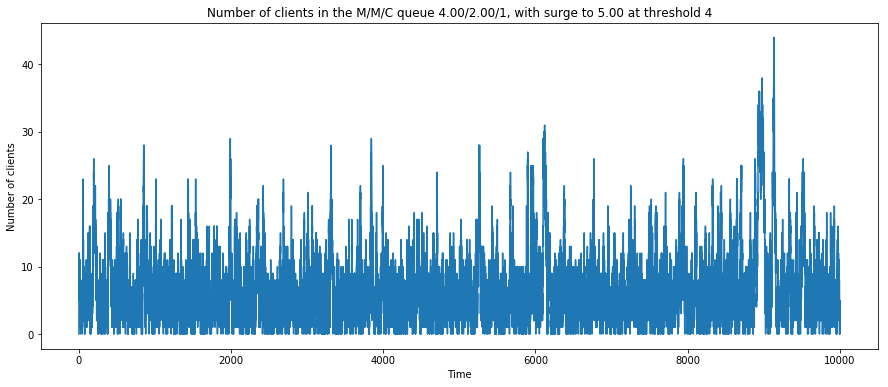

In [4]:
# lambda = arrival rate, exponentially distributed
# mu = service rate, exponentially distributed
# gamma = patience rate, exponentially distributed
# c = number of servers

'''lambd = .999
mu1 = .95
mu2 = 2
surge_threshold = 5'''
lambd = 4
mu1 = 2
mu2 = 5
surge_threshold = 4
c = 1
N0 = 0
Tmax = 10**4

T, N, W, S, in_surge = MM1WithOneThreshold(lambd, mu1, mu2, surge_threshold, c, N0, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with surge to %.2f at threshold %d'
      % (lambd, mu1, c, mu2, surge_threshold))

T_diff = [(T[i+1] - T[i]) for i in range(len(T) - 1)]
t_max = T_diff[-1]
t_tenth = T_diff[8008]
Q_sim = np.dot(T_diff[8008:], N[8008:-1]) / (T[-1] - T[8008])
print("Simulation average queue length (calculated after method): %f" % (Q_sim))

N_surge = [1*(N[i] >= surge_threshold) for i in range(len(N))]
p_surge_sim = np.dot(T_diff[8008:], N_surge[8008:-1]) / (T[-1] - T[8008])
print("Simulation p_surge (calculated after method): %f" % (p_surge_sim))

print("Simulation average queue length (calculated within method): %f" % (S))
print("Simulation p_surge (calculated within method): %f" % (in_surge))

coefs = [(lambd**i) / (mu1**min(i, surge_threshold - 1)*mu2**max(0, i-surge_threshold + 1)) for i in range(0, 1000)]
pi0 = 1 / (sum(coefs))
pis = [coefs[i] * pi0 for i in range(len(coefs))]
Q_expected = sum([i * pis[i] for i in range(len(pis))])
p_expected = sum(pis[surge_threshold:])
print("Expected average queue length: %f" % (Q_expected))
print("Expected p_surge: %f" % (p_expected))

In [5]:
# experiment to make sure that theoretical expected average queue length formula
# and expected probability of time we are in surge are implemented correctly

lambd = 4
surge_threshold = 4
mu1 = 2
mu2 = 5

coefs = [(lambd**i) / (mu1**min(i, surge_threshold - 1)*mu2**max(0, i-surge_threshold + 1)) for i in range(0, 6)]
pi0 = 1 / (sum(coefs))
pis = [coefs[i] * pi0 for i in range(len(coefs))]
Q_expected = sum([i * pis[i] for i in range(len(pis))])
p_expected = sum(pis[surge_threshold:])
print("Expected average queue length: %f" % (Q_expected))
print("Expected p_surge: %f" % (p_expected))

Expected average queue length: 3.212670
Expected p_surge: 0.434389


In [6]:
# now, see how threshold affects queue length 

lambd = 4
mu1 = 3
mu2 = 8
c = 1
N0 = 0
Tmax = 10**4

threshold = []
avg_queue_len = []
p_surge = []

for surge_threshold in range(2, 15):
    _,_,_, S, in_surge = MM1WithOneThreshold(lambd, mu1, mu2, surge_threshold, c, N0, Tmax)
    threshold.append(surge_threshold)
    avg_queue_len.append(S)
    p_surge.append(in_surge)

Text(0.5,1,'Average Queue Length in the M/M/C queue 4.00/3.00/1, with surge to 8.00 at different thresholds')

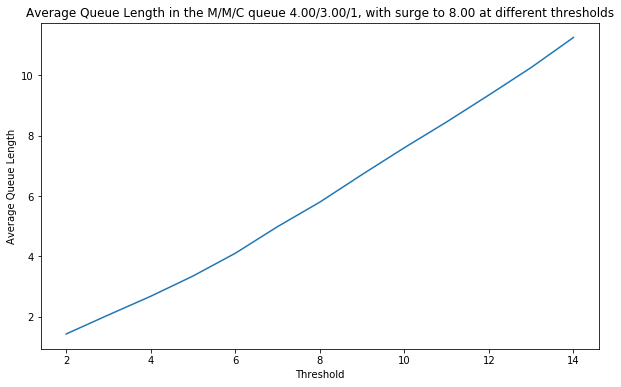

In [7]:
figure(figsize=(10,6))
plot(threshold, avg_queue_len)
xlabel('Threshold')
ylabel('Average Queue Length')
title('Average Queue Length in the M/M/C queue %.2f/%.2f/%d, with surge to %.2f at different thresholds' % (lambd, mu1, c, mu2))

Text(0.5,1,'p_surge in the M/M/C queue 4.00/3.00/1, with surge to 8.00 at different thresholds')

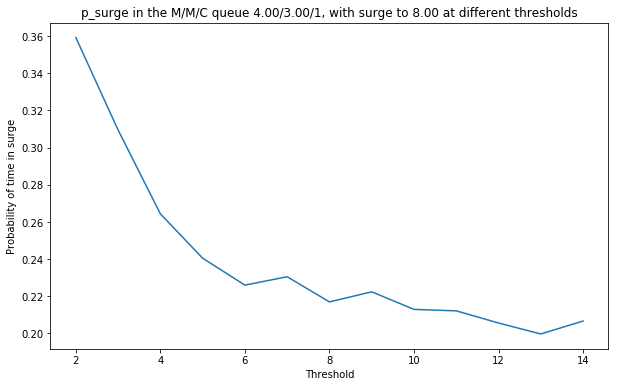

In [8]:
figure(figsize=(10,6))
plot(threshold, p_surge)
xlabel('Threshold')
ylabel('Probability of time in surge')
title('p_surge in the M/M/C queue %.2f/%.2f/%d, with surge to %.2f at different thresholds' % (lambd, mu1, c, mu2))